In [1]:
%load_ext autoreload
%autoreload 2
import scanpy as sc
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scvi
import pandas as pd
import scanpy_helpers.de as de
import altair as alt
from IPython.core.display import display, HTML

sc.set_figure_params(figsize=(5, 5))

In [2]:
gene_sets = {
    "C-type Lectins": (
        """
        CLEC7A 
        CLEC1A
        CLEC14A
        CLEC4E
        CLEC6A 
        CLEC4C 
        CLEC5A
        CD209 
        CLEC4A
        CLEC12A
        CLEC9A
        CLEC12B
        OPRL1 
        CLEC3B
        CLEC4A 
        CLEC2D
        KLRB1 
        MRC1
        KLRD1
        WDFY4
        """
    ).split(),
    "TLRs": (
        """
        TLR1
        TLR2
        TLR3
        TLR4
        TLR5
        TLR6
        TLR7
        TLR8
        TLR10
        """
    ).split(),
    "Intracellulaar PRR": (
        """
        STING1
        CGAS
        ADA
        DDX58
        NOD1
        NOD2
        NLRP3
        NLRC4
        NLRP1
        """
    ).split(),
    "Downstream": (
        """
        TICAM1
        TICAM2
        AGER
        NFATC1
        NFATC2
        NFATC3
        NFATC4
        NFAT5
        TIRAP
        MYD88
        IRAK4
        IRAK1
        TRAF3
        TRAF6
        IKBKE
        IKBKB
        MAP3K7
        IRF7
        NFKB1
        NFKB2
        RIPK2
        ICE1
        IFIH1
        IRF3
        DHX58
        NWD1
        """
    ).split(),
    "Downstream Cytokines/ILs": (
        """
        CCL2
        CCL5
        CCL7
        CXCL8
        CXCL10
        CXCR6
        IL6
        IL12B
        IL23R
        IL17RA
        IL1B
        IL18
        IFNG
        IL2
        PLD3
        PLD4
        IL5
        IL10
        """
    ).split(),
    "STING-related genes": (
        """
        STING1
        CGAS
        IKBKB
        IRF3
        STAT6
        TBK1
        TRAF6
        TRAF3
        NFKB1
        NFKB2
        IFNB1
        CCL7
        CCL2
        CCL20
        DDX41
        IFI16
        ISG15
        ISG20
        ISG20L2
        IL6
        IL7
        IL1A
        IL1B
        CXCL1
        CXCL10
        CXCL8
        IFIT1
        PLD3
        """
    ).split(),
}

In [3]:
res_dir = "../../data/70_plots/71_de_analysis"

In [4]:
adata = sc.read_h5ad("../../data/60_infercnv/all-annotated-integrated.h5ad")
adata_scvi = sc.read_h5ad(
    "../../data/50_integrate_scrnaseq_data/52_run_scanvi/integrated_merged_all.h5ad"
)

In [5]:
%%capture
scvi_model = scvi.model.SCANVI.load(
    "../../data/50_integrate_scrnaseq_data/52_run_scanvi/scvi_model_merged_all/",
    adata=adata_scvi,
)

In [6]:
adata.obs["condition"].unique()

['LUAD', 'LSCC', 'healthy_control', 'COPD', 'NSCLC']
Categories (5, object): ['LUAD', 'LSCC', 'healthy_control', 'COPD', 'NSCLC']

In [7]:
adata.obs["disease_state"] = "other"
adata.obs.loc[
    adata.obs["condition"] == "healthy_control", "disease_state"
] = "healthy_control"
adata.obs.loc[
    adata.obs["origin"].isin(["tumor_primary", "tumor_metastasis"]), "disease_state"
] = "tumor"
adata.obs.loc[adata.obs["condition"] == "COPD", "disease_state"] = "COPD"

In [8]:
adata.obs.groupby(["dataset", "disease_state"]).size().reset_index(name="count")

dataset    disease_state  count
0                  Adams_Kaminski_2020_COPD             COPD  69064
1                  Adams_Kaminski_2020_COPD  healthy_control  95885
2                  Adams_Kaminski_2020_COPD            other      0
3                  Adams_Kaminski_2020_COPD            tumor      0
4               Goveia_Carmeliet_2020_NSCLC             COPD      0
5               Goveia_Carmeliet_2020_NSCLC  healthy_control      0
6               Goveia_Carmeliet_2020_NSCLC            other  15577
7               Goveia_Carmeliet_2020_NSCLC            tumor  24249
8                      Guo_Zhang_2018_NSCLC             COPD      0
9                      Guo_Zhang_2018_NSCLC  healthy_control      0
10                     Guo_Zhang_2018_NSCLC            other   1785
11                     Guo_Zhang_2018_NSCLC            tumor   5504
12                Lambrechts_2018_LUAD_6149             COPD      0
13                Lambrechts_2018_LUAD_6149  healthy_control      0
14                Lambrechts_2018_LUAD_6149            other  19202
15                Lambrechts_2018_LUAD_6149            tumor  20246
16                Lambrechts_2018_LUAD_6653             COPD      0
17                Lambrechts_2018_LUAD_6653  healthy_control      0
18                Lambrechts_2018_LUAD_6653            other  15031
19                Lambrechts_2018_LUAD_6653            tumor  11570
20             Laughney_Massague_2020_NSCLC             COPD      0
21             Laughney_Massague_2020_NSCLC  healthy_control      0
22             Laughney_Massague_2020_NSCLC            other  10420
23             Laughney_Massague_2020_NSCLC            tumor  19215
24                  Lukassen_Eils_2020_LUAD             COPD      0
25                  Lukassen_Eils_2020_LUAD  healthy_control      0
26                  Lukassen_Eils_2020_LUAD            other  39778
27                  Lukassen_Eils_2020_LUAD            tumor      0
28  Madissoon_Meyer_2020_pulmonary-fibrosis             COPD      0
29  Madissoon_Meyer_2020_pulmonary-fibrosis  healthy_control  57020
30  Madissoon_Meyer_2020_pulmonary-fibrosis            other      0
31  Madissoon_Meyer_2020_pulmonary-fibrosis            tumor      0
32                   Maier_Merad_2020_NSCLC             COPD      0
33                   Maier_Merad_2020_NSCLC  healthy_control      0
34                   Maier_Merad_2020_NSCLC            other   2800
35                   Maier_Merad_2020_NSCLC            tumor   3285
36                Maynard_Bivona_2020_NSCLC             COPD      0
37                Maynard_Bivona_2020_NSCLC  healthy_control      0
38                Maynard_Bivona_2020_NSCLC            other    872
39                Maynard_Bivona_2020_NSCLC            tumor  16912
40    Mayr_Schiller_2020_pulmonary-fibrosis             COPD      0
41    Mayr_Schiller_2020_pulmonary-fibrosis  healthy_control  96774
42    Mayr_Schiller_2020_pulmonary-fibrosis            other      0
43    Mayr_Schiller_2020_pulmonary-fibrosis            tumor      0
44                     Pircher_batch1_NSCLC             COPD      0
45                     Pircher_batch1_NSCLC  healthy_control      0
46                     Pircher_batch1_NSCLC            other  11617
47                     Pircher_batch1_NSCLC            tumor  14528

In [9]:
adata.obs["disease_state"].value_counts()

healthy_control    249679
other              117082
tumor              115509
COPD                69064
Name: disease_state, dtype: int64

In [10]:
adata = adata[(adata.obs["disease_state"] != "other"), :]

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
# Cell-types of interest
cell_types_coarse = {
    "B cell": True,
    "cDC1": True,
    "cDC2": True,
    "Ciliated": True,
    "mDC mature": True,
    "Endothelial cell": True,
    "Endothelial cell lymphatic": True,
    "Epithelial cell": [
        "Epithelial cell other (benign)",
        "Club/Goblet",
        "Alevolar cell type 1",
        "Alevolar cell type 2",
    ],
    "Fibroblast": ["Fibroblast adventitial", "Fibroblast", "Fibroblast alevolar"],
    "stromal (non-Fibroblast)": [
        "Smooth muscle cell",
        "Pericyte",
        "Mesothelial",
        "stromal other",
    ],
    "Monocyte": ["Monocyte non-conventional", "Monocyte conventional"],
    "Macrophage": ["Macrophage", "Macrophage FABP4+"],
    "Plasma cell": True,
    "Mast cell": ["other"],
    "myeloid (other)": ["myeloid other"],
    "T cell": ["T cell CD8", "T cell CD4", "T cell dividing", "T reg"],
    "NK cell": True,
    "Epithelial cell (malignant)": True,
}

In [12]:
adata.obs["cell_type_coarse"] = "other"
for new_label, cell_types in cell_types_coarse.items():
    if cell_types is True:
        cell_types = [new_label]
    for tmp_cell_type in cell_types:
        mask = adata.obs["cell_type"] == tmp_cell_type
        assert np.sum(mask), f"{tmp_cell_type} not found!"
        adata.obs.loc[mask, "cell_type_coarse"] = new_label

Trying to set attribute `.obs` of view, copying.


... storing 'disease_state' as categorical
... storing 'cell_type_coarse' as categorical


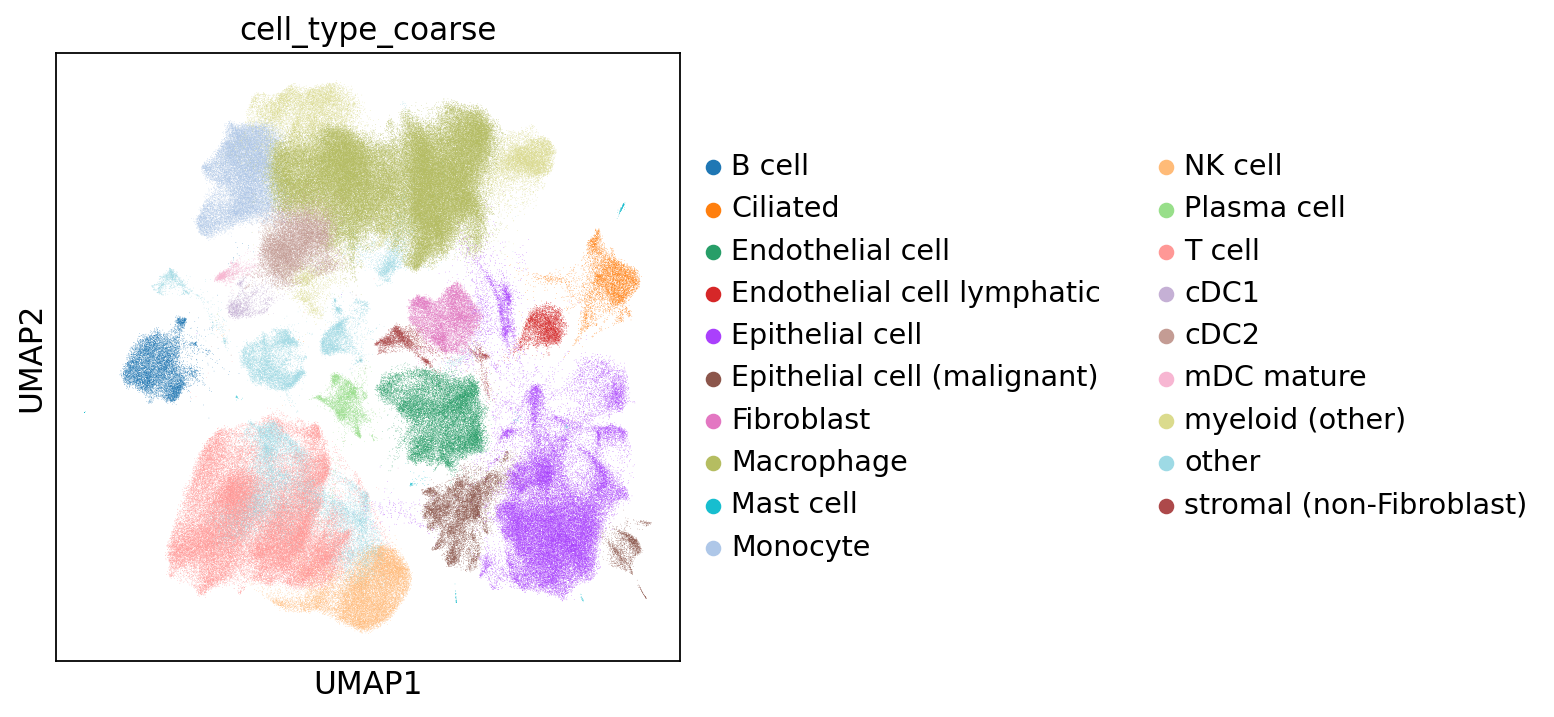

In [13]:
sc.pl.umap(adata, color="cell_type_coarse")

In [14]:
adata.obs["cell_type_disease_state"] = [
    f"{ct}_{ds}"
    for ct, ds in zip(adata.obs["cell_type_coarse"], adata.obs["disease_state"])
]

In [15]:
adata_scvi.obs["disease_state"] = adata.obs["disease_state"]
adata_scvi.obs["cell_type_coarse"] = adata.obs["cell_type_coarse"]
adata_scvi.obs["cell_type_disease_state"] = adata.obs["cell_type_disease_state"]
adata_scvi.obs["cell_type_dataset_disease_state"] = [
    f"{cell_type}_{dataset}_{disease_state}"
    for cell_type, dataset, disease_state in zip(
        adata_scvi.obs["cell_type_coarse"],
        adata_scvi.obs["dataset"],
        adata_scvi.obs["disease_state"],
    )
]

In [ ]:
results = []
for cell_type in adata.obs["cell_type_coarse"].unique():
    res = scvi_model.differential_expression(
        adata_scvi[adata_scvi.obs["cell_type_coarse"] == cell_type, :],
        groupby="disease_state",
        group1=["tumor", "COPD"],
        group2="healthy_control",
        batch_correction=True,
        mode="change",
    ).assign(cell_type=cell_type)
    results.append(res)

In [20]:
res_all = pd.concat(results)

In [21]:
res_all.to_csv(f"{res_dir}/de_scvi.csv")

In [22]:
res_all.loc[
    (res_all["raw_normalized_mean1"] > 0.5) | (res_all["raw_normalized_mean2"] > 0.5), :
].to_csv(f"{res_dir}/de_scvi_filtered.csv")

## pseudobulk-Analyses

In [20]:
ad = de.make_pseudobulk(
    adata_scvi,
    groupby="cell_type_dataset_disease_state",
    include_variables=["cell_type_coarse", "dataset", "disease_state"],
)

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
ad.obs["cell_threshold"] = ad.obs["n_cells"] >= 100

In [22]:
sc.pp.normalize_total(ad, target_sum=1e6)

In [23]:
def make_chart(ad, cell_type, gene_set):
    tmp_adata = ad[ad.obs["cell_type_coarse"] == cell_type, gene_sets[gene_set]]
    tmp_df = (
        pd.DataFrame(
            tmp_adata.X, index=tmp_adata.obs_names, columns=tmp_adata.var_names
        )
        .join(tmp_adata.obs)
        .melt(id_vars=tmp_adata.obs.columns, var_name="gene_symbol", value_name="cpm")
    )
    return (
        (
            alt.Chart(tmp_df)
            .mark_boxplot()
            .encode(x="disease_state", y="cpm")
            .properties(height=150)
            + (
                alt.Chart(tmp_df)
                .mark_circle(size=60, fillOpacity=1)
                .encode(
                    alt.X("disease_state", title=None),
                    y="cpm",
                    color=alt.Color("dataset", scale=alt.Scale(scheme="paired")),
                    stroke=alt.Stroke(
                        "cell_threshold",
                        scale=alt.Scale(
                            domain=["true", "false"], range=["black", "lightgrey"]
                        ),
                    ),
                )
            )
        )
        .facet("gene_symbol")
        .resolve_scale(y="independent")
        .properties(title=f"{cell_type}: {gene_set}")
    )

In [24]:
for gene_set in gene_sets.keys():
    display(HTML(f"<h3>{gene_set}</h3>"))
    display(
        alt.vconcat(
            *[
                make_chart(ad, ct, gene_set)
                for ct in ad.obs["cell_type_coarse"].unique()
                if not pd.isnull(ct)
            ]
        ).configure_mark(opacity=0.9)
    )

/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)